In [7]:
!unzip Dataset_v4_all_images.zip #extract dataset to the current directory. 

# Hyperparameters
- We use SGD for optimizing discriminator, use Adam (use default lr=0.001) for optimizing generator to make sure the generator learns at relatively similar speed of discriminator. Otherwise, because it is easier for discriminator to learn its task than generator, if the discriminator learns too fast, its training loss will soon reach 0, then the generator cannot keep up with it and will never be able to learn to fool the discriminator.

- The length of random vector used to generate the fake image is 1000

### Hyperparameters we adjusted:
  - We tried with 2 models: one has 7 layers for both discriminator and generator, the other has 5 layers
  - Resizing the images to either 256\*256 or 64\*64
  - Batch size: 64, 25
  - Number of epochs: 20, 60, 100, 200, 300
  - Learning rate of the discriminator optimizer (SGD): 0.001, 0.01, 0.005



# Results:
- Only for result 1, I did not change the plot to RGB so the result image is in grayscale
- All the other results are in RGB

### Result 1
- 7-layer model
- Resizing the images to 256\*256
- Batch size: 64
- Number of epochs: 20
- Learning rate of the discriminator optimizer (SGD): 0.001
<img src="Result_images/result_1_final.jpg",width=400, height=400>
<img src="Result_images/result1_curve.png",width=400, height=400>

### Result 2
- 7-layer model
- Resizing the images to 256\*256
- Batch size: 64
- Number of epochs: 20
- Learning rate of the discriminator optimizer (SGD): 0.01
<img src="Result_images/2_epoch20.png",width=400, height=400>
<img src="Result_images/result2_curve.png",width=400, height=400>

### Result 3
- 7-layer model
- Resizing the images to 256\*256
- Batch size: 64
- Number of epochs: 60
- Learning rate of the discriminator optimizer (SGD): 0.01
<img src="Result_images/3_epoch60.png",width=400, height=400>
<img src="Result_images/result3_curve.png",width=400, height=400>

### Result 4
- 5-layer model
- Resizing the images to 64\*64
- Batch size: 64
- Number of epochs: 100
- Learning rate of the discriminator optimizer (SGD): 0.01
<img src="Result_images/4_epoch100.png",width=400, height=400>
<img src="Result_images/result4_curve.png",width=400, height=400>

### Result 5
- 5-layer model
- Resizing the images to 64\*64
- Batch size: 64
- Number of epochs: 200
- Learning rate of the discriminator optimizer (SGD): 0.01
<img src="Result_images/5_epoch200.png",width=400, height=400>
<img src="Result_images/result5_curve.png",width=400, height=400>

### Result 6
- 5-layer model
- Resizing the images to 64\*64
- Batch size: 25
- Number of epochs: 200
- Learning rate of the discriminator optimizer (SGD): 0.01
<img src="Result_images/6_epoch200.png",width=400, height=400>
<img src="Result_images/result6_curve.png",width=400, height=400>

### Result 7
- 5-layer model
- Resizing the images to 64\*64
- Batch size: 25
- Number of epochs: 200
- Learning rate of the discriminator optimizer (SGD): 0.005
<img src="Result_images/7_epoch200.png",width=400, height=400>
<img src="Result_images/result7_curve.png",width=400, height=400>

### Result 8
- 5-layer model
- Resizing the images to 64\*64
- Batch size: 25
- Number of epochs: 300
- Learning rate of the discriminator optimizer (SGD): 0.005
<img src="Result_images/8_epoch100.png",width=400, height=400>
<img src="Result_images/8_epoch300.png",width=400, height=400>
<img src="Result_images/result8_curve.png",width=400, height=400>



# Summary:
- If the learning rate of SGD (discriminator optimizer) is too slow (such as 0.001 in Result 1 compared to 0.01 in result 2), then the loss of discriminator is always high, and the result images do not look so good.
- The results from using the 5-layer model and resize image to 64\*64 (result 4) is not worse than the 7-layer model and resize image to 256\*256 (result 3). So later on we used the simpler model and 64\*64.
- Change from a batch size of 64 to 25 (from result 5 to result 6) seems to improve the quality of resulting fake images. There are less noise and artefacts.
- Because the D-loss and G-loss curves of result 6 deviates from each other already from around epoch 35, so we tried decreasing the learning rate of SGD (discriminator optimizer) from 0.01 to 0.005 (from result 6 to result 7). But the result images actually look not so real than result 6.
- In result 8, we added more epoches (300). The result of the 300th result and 100th result do not differ too much, but the details of the 300th epoch seem to be more real.
- Overall, we think the hyperparameters of result 6 leads to the most real-looking fake images in the end, and the gif of result 6 is: 
<img src="Result_images/result_6.gif",width=400, height=400>


In [2]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


### Define discriminator and generator

In [3]:
# # For input images of size 256*256
# # G(z)
# class generator(nn.Module):
#     # initializers
#     def __init__(self, d=128):
#         super(generator, self).__init__() #original: batch*1000*1*1-->each faked image is generated from a 1000*1*1 tensor
#         self.deconv1 = nn.ConvTranspose2d(1000, d*8, 4, 1, 0)  # batch*8d*4*4
#         self.deconv1_bn = nn.BatchNorm2d(d*8)
#         self.deconv2 = nn.ConvTranspose2d(d*8, d*8, 4, 2, 1)  # batch*8d*8*8
#         self.deconv2_bn = nn.BatchNorm2d(d*8)
#         self.deconv3 = nn.ConvTranspose2d(d*8, d*8, 4, 2, 1)  # batch*8d*16*16
#         self.deconv3_bn = nn.BatchNorm2d(d*8)
#         self.deconv4 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)  # batch*4d*32*32
#         self.deconv4_bn = nn.BatchNorm2d(d*4)
#         self.deconv5 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # batch*2d*64*64
#         self.deconv5_bn = nn.BatchNorm2d(d*2)
#         self.deconv6 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # batch*d*128*128
#         self.deconv6_bn = nn.BatchNorm2d(d)
#         self.deconv7 = nn.ConvTranspose2d(d, 3, 4, 2, 1) # # batch*1*256*256

#     # weight_init
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)

#     # forward method
#     def forward(self, input):
#         # x = F.relu(self.deconv1(input))
#         x = F.relu(self.deconv1_bn(self.deconv1(input)))
#         x = F.relu(self.deconv2_bn(self.deconv2(x)))
#         x = F.relu(self.deconv3_bn(self.deconv3(x)))
#         x = F.relu(self.deconv4_bn(self.deconv4(x)))
#         x = F.relu(self.deconv5_bn(self.deconv5(x)))
#         x = F.relu(self.deconv6_bn(self.deconv6(x)))
#         x = F.tanh(self.deconv7(x))

#         return x

# class discriminator(nn.Module):
#     # initializers
#     def __init__(self, d=128):
#         super(discriminator, self).__init__() # original: batch*3*256*256
#         self.conv1 = nn.Conv2d(3, d, 4, 2, 1) # batch*d*128*128
#         self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # batch*2d*64*64
#         self.conv2_bn = nn.BatchNorm2d(d*2) 
#         self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # batch*4d*32*32
#         self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # batch*8d*16*16
#         self.conv4_bn = nn.BatchNorm2d(d*8)
#         self.conv5 = nn.Conv2d(d*8, d*8, 4, 2, 1) # batch*8d*8*8
#         self.conv5_bn = nn.BatchNorm2d(d*8)
#         self.conv6 = nn.Conv2d(d*8, d*8, 4, 2, 1) # batch*8d*4*4
#         self.conv6_bn = nn.BatchNorm2d(d*8)
#         self.conv7 = nn.Conv2d(d*8, 1, 4, 1, 0) # batch*1*1*1 torch.squeeze() is used after forward of discriminator!!

#     # weight_init
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)

#     # forward method
#     def forward(self, input):
#         x = F.leaky_relu(self.conv1(input), 0.2)
#         x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
#         x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
#         x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
#         x = F.leaky_relu(self.conv6_bn(self.conv6(x)), 0.2)
#         x = F.sigmoid(self.conv7(x))

#         return x

# def normal_init(m, mean, std):
#     if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
#         m.weight.data.normal_(mean, std)
#         m.bias.data.zero_()

In [4]:
# For input images of size 256*256
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__() #original: batch*1000*1*1-->each faked image is generated from a 1000*1*1 tensor
        self.deconv1 = nn.ConvTranspose2d(1000, d*8, 4, 1, 0)  # batch*8d*4*4
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)  # batch*4d*8*8
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # batch*2d*16*16
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # batch*d*32*32
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1) # # batch*1*64*64

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__() # original: batch*3*64*64
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1) # batch*d*32*32
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # batch*2d*16*16
        self.conv2_bn = nn.BatchNorm2d(d*2) 
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # batch*4d*8*8
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # batch*8d*4*4
        self.conv4_bn = nn.BatchNorm2d(d*8)

        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0) # batch*1*1*1 torch.squeeze() is used after forward of discriminator!!

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

### Show 25 result images of generator, and show histogram of training loss

In [5]:
fixed_z_ = torch.randn((5 * 5, 1000)).view(-1, 1000, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 1000)).view(-1, 1000, 1, 1) # 25*1000*1*1
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        sub_image=test_images[k].cpu().data.numpy().transpose(1,2,0) # make it a RGB image
        sub_image_normed=(sub_image-sub_image.mean(axis=(0,1)))/(sub_image.std(axis=(0,1))*6)+0.5 # Normalize the image, to a mean of 0.5
        sub_image_normed.clip(0,1,out=sub_image_normed) # clip the value between 0 and 1
        ax[i, j].imshow(sub_image_normed) 

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save==True:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### Training parameters

In [6]:
batch_size = 25
lr_D = 0.005 # learning rate for Discriminator
lr_G = 0.001 # learning rate for Generator
train_epoch = 300


### Loading data (image size scaled from 28\*28 to 64\*64)

In [8]:
# # Remove .DS_Store files
# import os
# for folder in ['Dataset_v4_all_images','Dataset_v4_all_images/no_soccer','Dataset_v4_all_images/soccer']:
#     for file in os.listdir(folder):
#         # print(type(file))
#         if file.endswith('.DS_Store'):
#             print(file)
#             os.remove(os.path.join(folder,file))
    

In [9]:
# data_loader
img_size = 64 # Used: 1-256, 2-64
transform = transforms.Compose([
        transforms.Scale(img_size), # !! Image size is scaled to 256*256 instead of original size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

soccer_images = datasets.ImageFolder('Dataset_v4_all_images', transform)

train_loader = torch.utils.data.DataLoader(
    dataset=soccer_images,
    batch_size=batch_size, shuffle=True)

/home/local/stud/zhaoy/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [10]:
# Check the size of image
for x_, _ in train_loader:
    print(x_.size())
    break

torch.Size([25, 3, 64, 64])


### Initialize generator, discriminator, loss and optimizer

In [ ]:
# network
G = generator(64)
D = discriminator(64)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
D_optimizer = optim.SGD(D.parameters(), lr=lr_D) # Use SGD to make discriminator learn slowlier
# Use SGD for Disctiminator instead: to make it learn slower


### Training and showing results

training start!
[1/300] - ptime: 9.42, loss_d: 1.762, loss_g: 5.434
Epoch 1: Training losses so far:


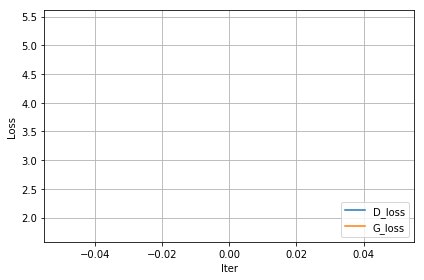

[2/300] - ptime: 9.63, loss_d: 1.071, loss_g: 8.416
Epoch 2: Training losses so far:


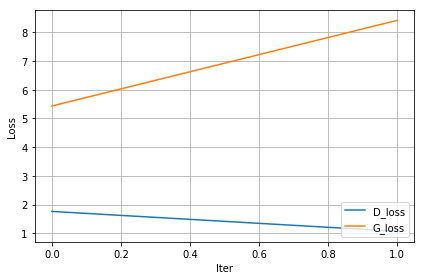

[3/300] - ptime: 9.77, loss_d: 0.511, loss_g: 5.248
Epoch 3: Training losses so far:


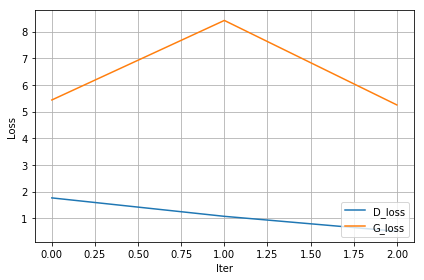

[4/300] - ptime: 9.56, loss_d: 1.227, loss_g: 2.434
Epoch 4: Training losses so far:


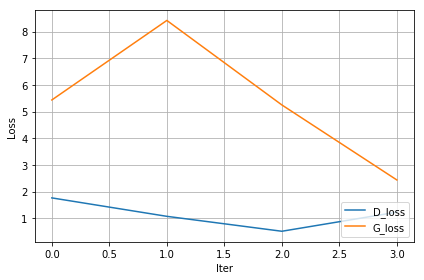

[5/300] - ptime: 9.52, loss_d: 1.131, loss_g: 2.019
Epoch 5: Training losses so far:


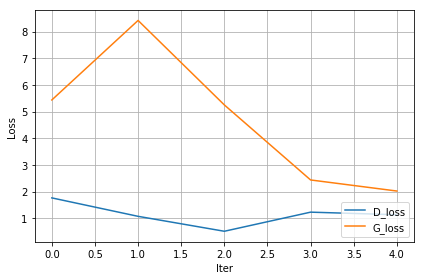

[6/300] - ptime: 9.75, loss_d: 1.159, loss_g: 1.786
Epoch 6: Training losses so far:


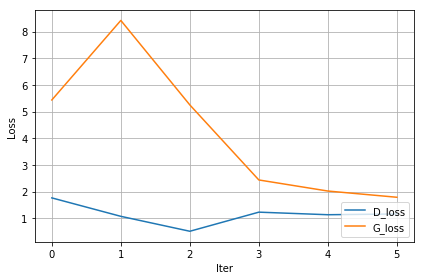

[7/300] - ptime: 9.60, loss_d: 1.147, loss_g: 1.642
Epoch 7: Training losses so far:


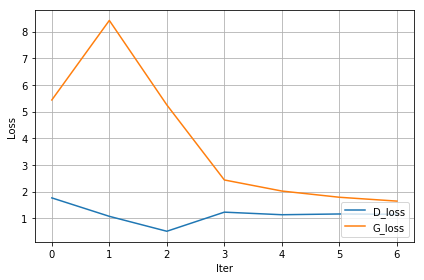

[8/300] - ptime: 9.55, loss_d: 1.281, loss_g: 1.499
Epoch 8: Training losses so far:


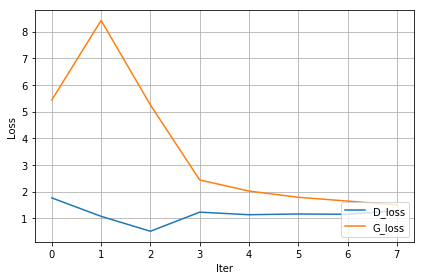

[9/300] - ptime: 9.71, loss_d: 1.304, loss_g: 1.428
Epoch 9: Training losses so far:


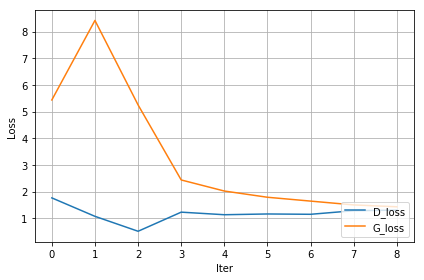

[10/300] - ptime: 9.57, loss_d: 1.178, loss_g: 1.418
Epoch 10: Training losses so far:


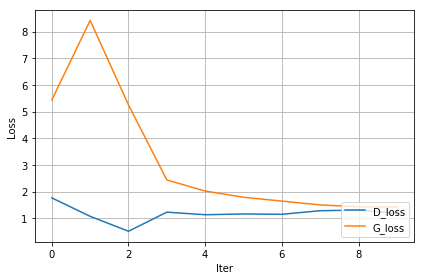

[11/300] - ptime: 9.47, loss_d: 1.249, loss_g: 1.502
Epoch 11: Training losses so far:


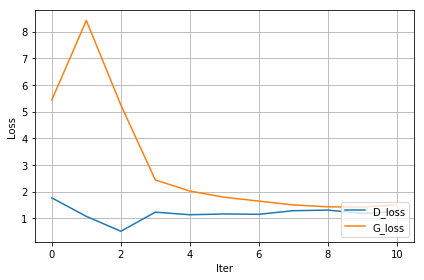

[12/300] - ptime: 9.75, loss_d: 1.179, loss_g: 1.261
Epoch 12: Training losses so far:


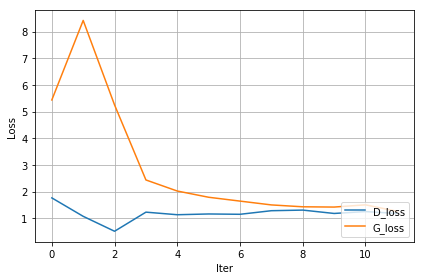

[13/300] - ptime: 9.57, loss_d: 1.451, loss_g: 1.305
Epoch 13: Training losses so far:


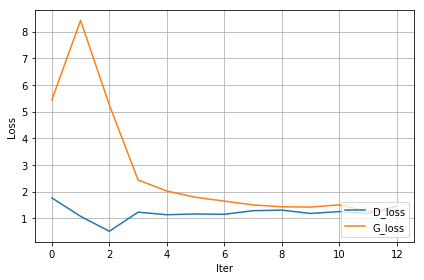

[14/300] - ptime: 9.63, loss_d: 1.288, loss_g: 1.289
Epoch 14: Training losses so far:


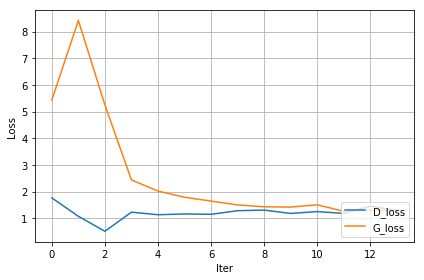

[15/300] - ptime: 9.78, loss_d: 1.324, loss_g: 1.248
Epoch 15: Training losses so far:


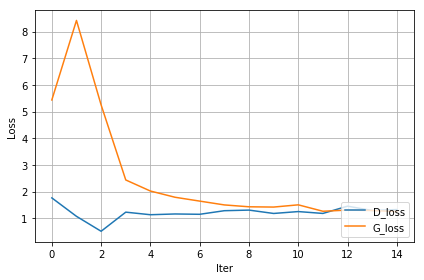

[16/300] - ptime: 9.66, loss_d: 1.319, loss_g: 1.168
Epoch 16: Training losses so far:


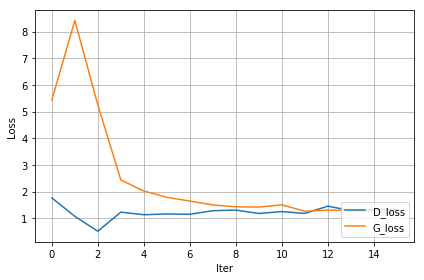

[17/300] - ptime: 9.63, loss_d: 1.402, loss_g: 1.254
Epoch 17: Training losses so far:


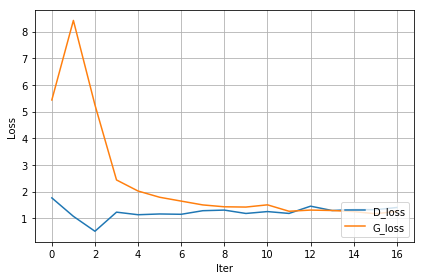

[18/300] - ptime: 9.70, loss_d: 1.271, loss_g: 1.150
Epoch 18: Training losses so far:


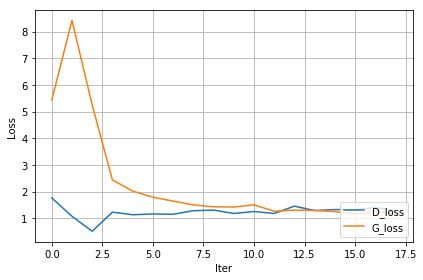

[19/300] - ptime: 9.74, loss_d: 1.313, loss_g: 1.179
Epoch 19: Training losses so far:


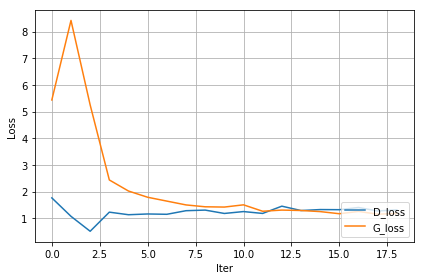

[20/300] - ptime: 9.58, loss_d: 1.287, loss_g: 1.179
Epoch 20: Training losses so far:


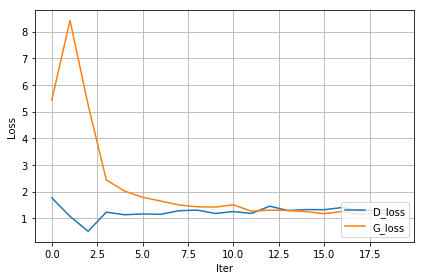

[21/300] - ptime: 9.57, loss_d: 1.274, loss_g: 1.144
Epoch 21: Training losses so far:


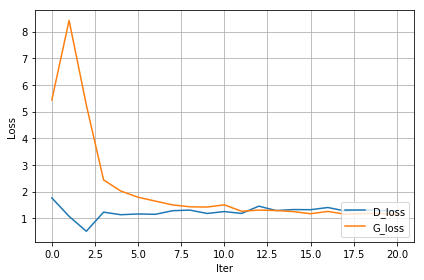

[22/300] - ptime: 9.79, loss_d: 1.277, loss_g: 1.094
Epoch 22: Training losses so far:


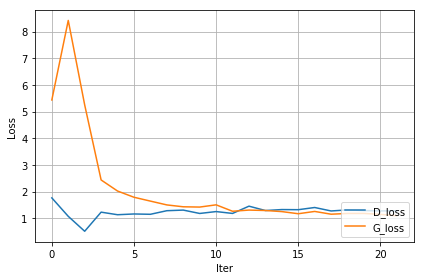

[23/300] - ptime: 9.64, loss_d: 1.321, loss_g: 1.097
Epoch 23: Training losses so far:


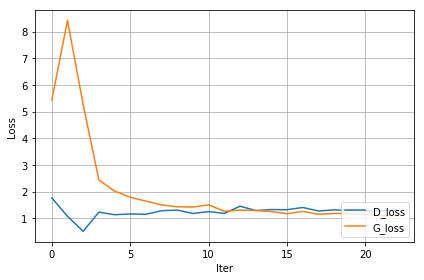

[24/300] - ptime: 9.56, loss_d: 1.294, loss_g: 1.099
Epoch 24: Training losses so far:


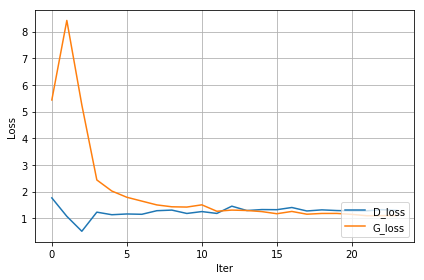

[25/300] - ptime: 9.80, loss_d: 1.229, loss_g: 1.077
Epoch 25: Training losses so far:


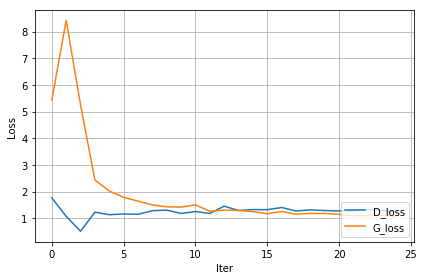

[26/300] - ptime: 9.62, loss_d: 1.269, loss_g: 1.086
Epoch 26: Training losses so far:


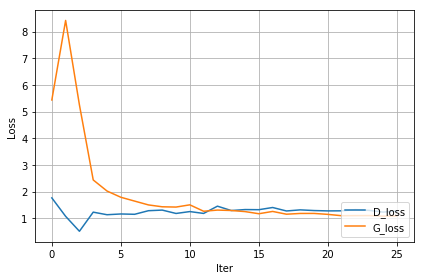

[27/300] - ptime: 9.56, loss_d: 1.242, loss_g: 1.074
Epoch 27: Training losses so far:


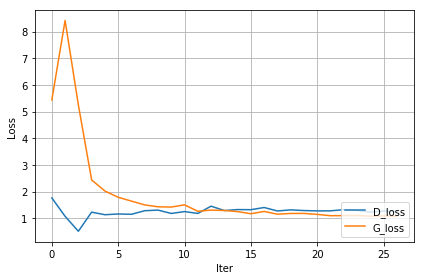

[28/300] - ptime: 9.69, loss_d: 1.238, loss_g: 1.072
Epoch 28: Training losses so far:


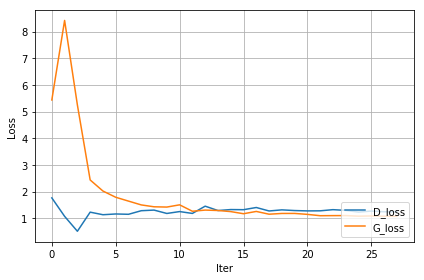

[29/300] - ptime: 9.55, loss_d: 1.282, loss_g: 1.110
Epoch 29: Training losses so far:


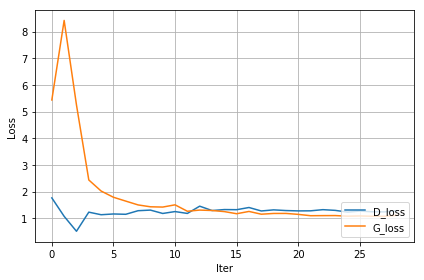

[30/300] - ptime: 9.57, loss_d: 1.332, loss_g: 1.084
Epoch 30: Training losses so far:


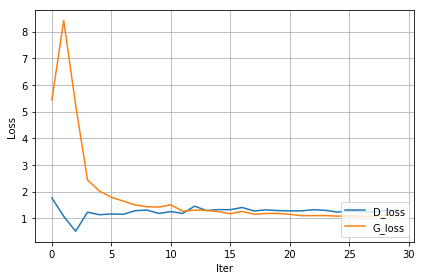

[31/300] - ptime: 9.74, loss_d: 1.304, loss_g: 1.065
Epoch 31: Training losses so far:


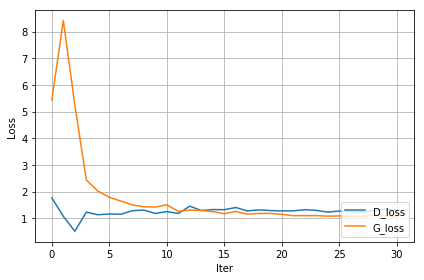

[32/300] - ptime: 9.55, loss_d: 1.292, loss_g: 1.063
Epoch 32: Training losses so far:


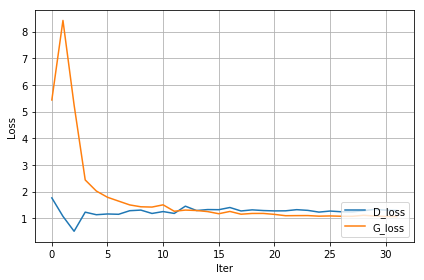

[33/300] - ptime: 9.64, loss_d: 1.225, loss_g: 1.108
Epoch 33: Training losses so far:


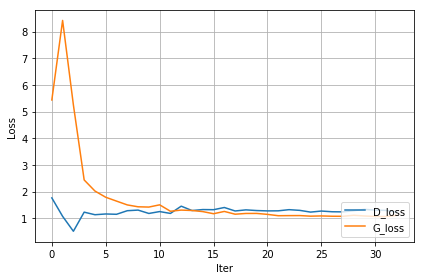

[34/300] - ptime: 9.75, loss_d: 1.272, loss_g: 1.071
Epoch 34: Training losses so far:


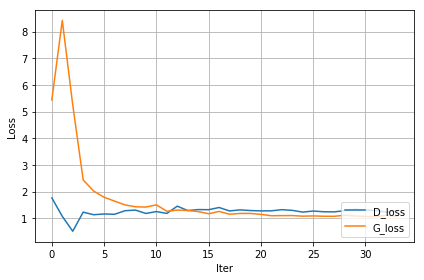

[35/300] - ptime: 9.56, loss_d: 1.278, loss_g: 1.044
Epoch 35: Training losses so far:


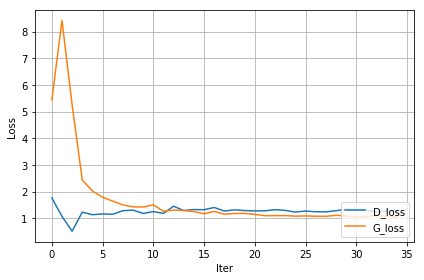

[36/300] - ptime: 9.60, loss_d: 1.238, loss_g: 1.028
Epoch 36: Training losses so far:


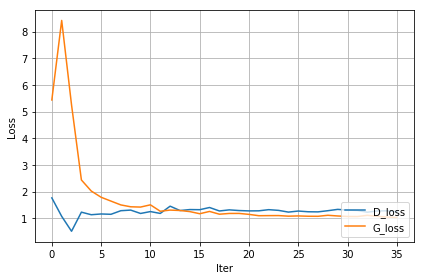

[37/300] - ptime: 9.80, loss_d: 1.243, loss_g: 1.056
Epoch 37: Training losses so far:


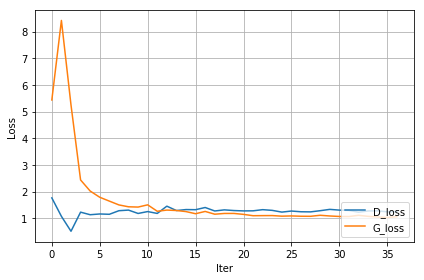

[38/300] - ptime: 9.56, loss_d: 1.256, loss_g: 1.034
Epoch 38: Training losses so far:


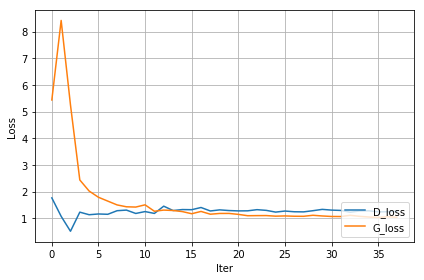

[39/300] - ptime: 9.57, loss_d: 1.247, loss_g: 1.058
Epoch 39: Training losses so far:


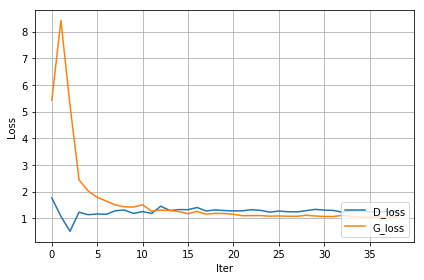

[40/300] - ptime: 9.86, loss_d: 1.275, loss_g: 1.126
Epoch 40: Training losses so far:


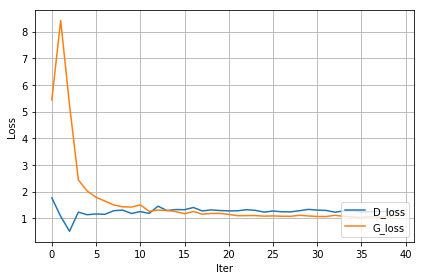

[41/300] - ptime: 9.66, loss_d: 1.293, loss_g: 0.991
Epoch 41: Training losses so far:


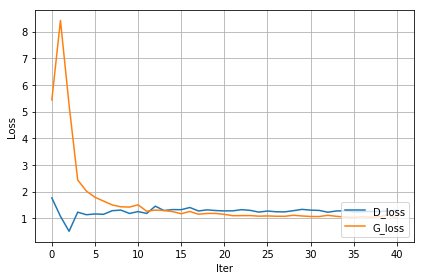

[42/300] - ptime: 9.57, loss_d: 1.276, loss_g: 0.998
Epoch 42: Training losses so far:


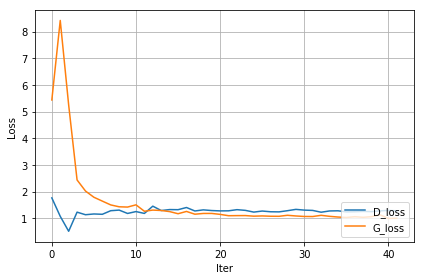

[43/300] - ptime: 9.69, loss_d: 1.241, loss_g: 1.029
Epoch 43: Training losses so far:


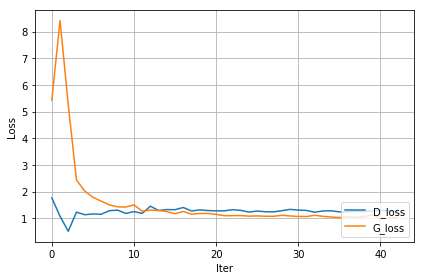

[44/300] - ptime: 9.78, loss_d: 1.234, loss_g: 1.031
Epoch 44: Training losses so far:


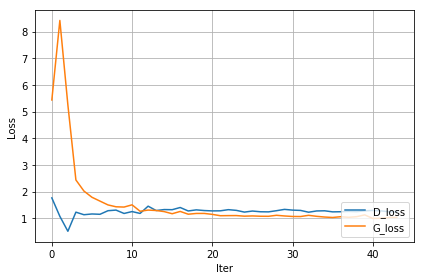

[45/300] - ptime: 9.62, loss_d: 1.272, loss_g: 1.054
Epoch 45: Training losses so far:


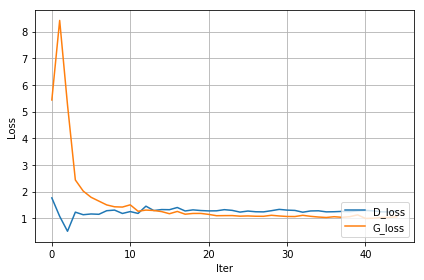

[46/300] - ptime: 9.64, loss_d: 1.278, loss_g: 1.022
Epoch 46: Training losses so far:


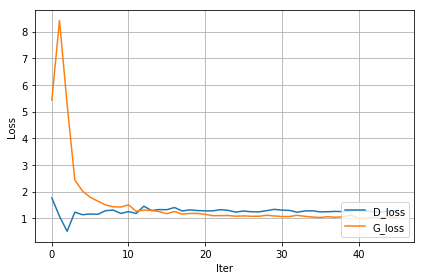

[47/300] - ptime: 9.77, loss_d: 1.278, loss_g: 0.997
Epoch 47: Training losses so far:


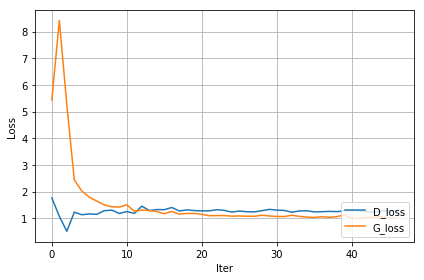

[48/300] - ptime: 9.58, loss_d: 1.206, loss_g: 1.024
Epoch 48: Training losses so far:


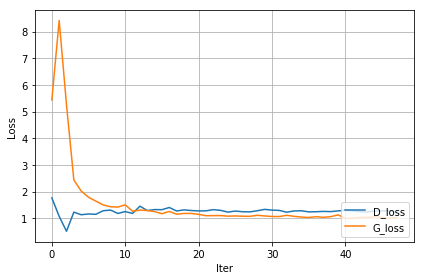

[49/300] - ptime: 9.69, loss_d: 1.224, loss_g: 0.996
Epoch 49: Training losses so far:


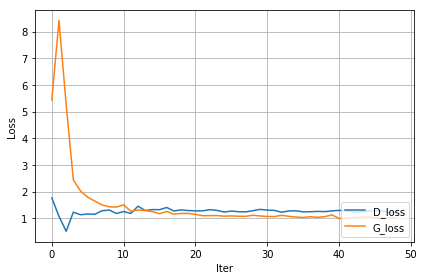

[50/300] - ptime: 9.78, loss_d: 1.234, loss_g: 1.002
Epoch 50: Training losses so far:


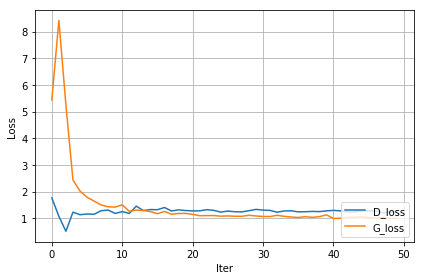

[51/300] - ptime: 9.59, loss_d: 1.244, loss_g: 1.032
Epoch 51: Training losses so far:


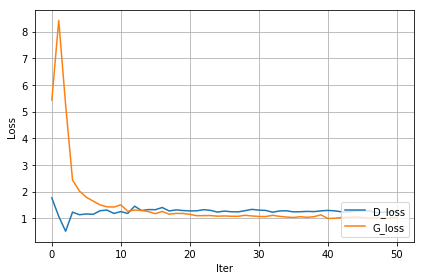

[52/300] - ptime: 9.70, loss_d: 1.245, loss_g: 0.993
Epoch 52: Training losses so far:


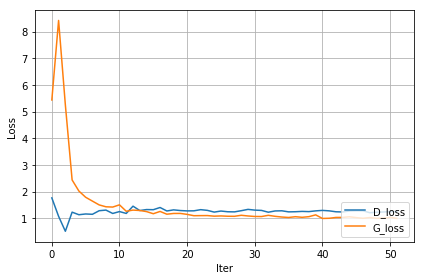

[53/300] - ptime: 9.79, loss_d: 1.286, loss_g: 0.981
Epoch 53: Training losses so far:


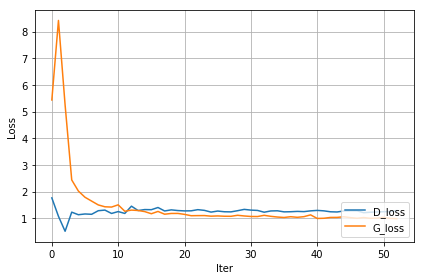

[54/300] - ptime: 9.48, loss_d: 1.350, loss_g: 1.034
Epoch 54: Training losses so far:


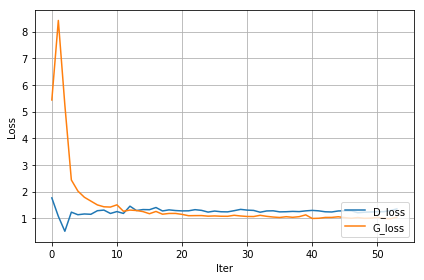

[55/300] - ptime: 9.76, loss_d: 1.285, loss_g: 0.992
Epoch 55: Training losses so far:


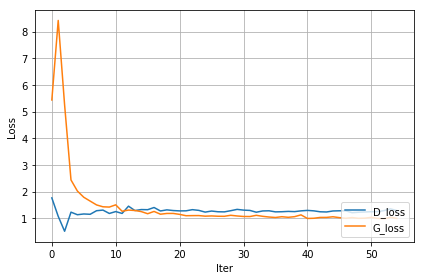

[56/300] - ptime: 9.86, loss_d: 1.263, loss_g: 1.003
Epoch 56: Training losses so far:


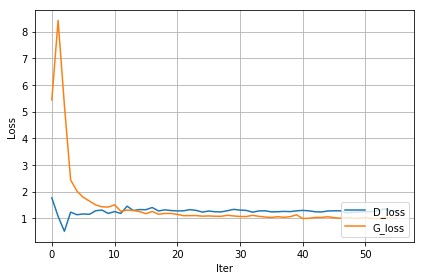

[57/300] - ptime: 9.67, loss_d: 1.241, loss_g: 1.004
Epoch 57: Training losses so far:


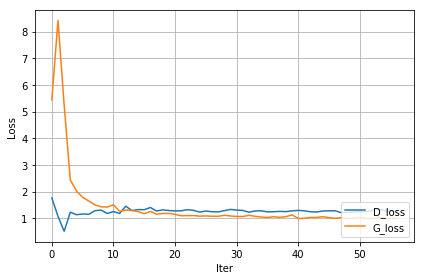

[58/300] - ptime: 9.68, loss_d: 1.230, loss_g: 1.005
Epoch 58: Training losses so far:


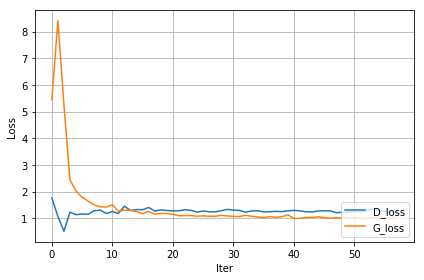

[59/300] - ptime: 9.83, loss_d: 1.265, loss_g: 0.986
Epoch 59: Training losses so far:


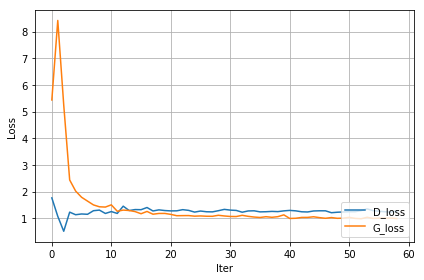

[60/300] - ptime: 9.73, loss_d: 1.328, loss_g: 1.042
Epoch 60: Training losses so far:


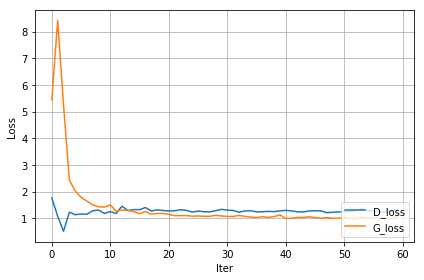

[61/300] - ptime: 9.58, loss_d: 1.259, loss_g: 1.035
Epoch 61: Training losses so far:


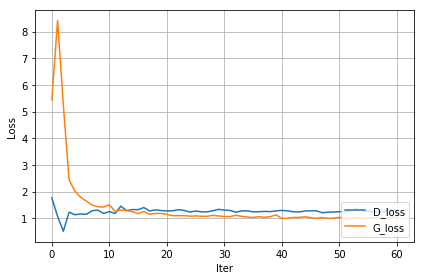

[62/300] - ptime: 9.76, loss_d: 1.248, loss_g: 1.011
Epoch 62: Training losses so far:


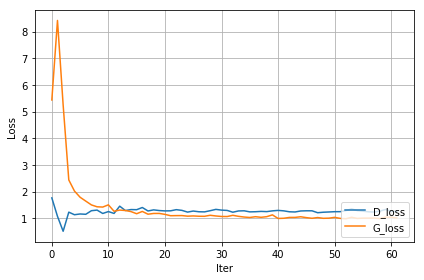

[63/300] - ptime: 9.86, loss_d: 1.282, loss_g: 1.028
Epoch 63: Training losses so far:


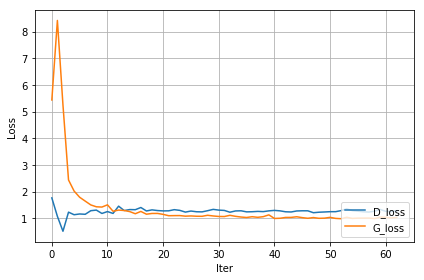

[64/300] - ptime: 9.56, loss_d: 1.227, loss_g: 0.972
Epoch 64: Training losses so far:


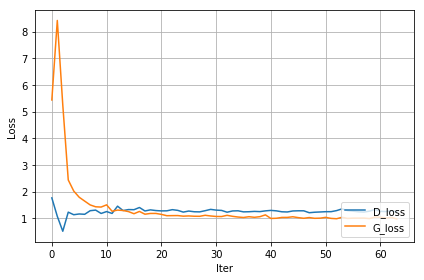

[65/300] - ptime: 9.79, loss_d: 1.266, loss_g: 0.960
Epoch 65: Training losses so far:


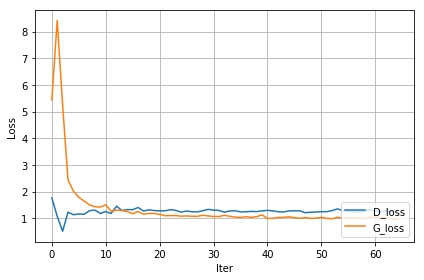

[66/300] - ptime: 9.74, loss_d: 1.204, loss_g: 1.065
Epoch 66: Training losses so far:


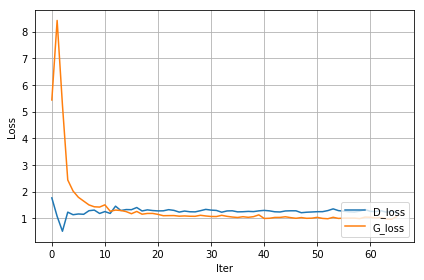

[67/300] - ptime: 9.59, loss_d: 1.235, loss_g: 0.994
Epoch 67: Training losses so far:


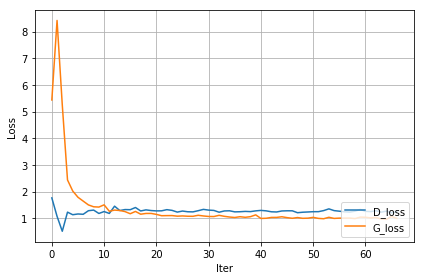

[68/300] - ptime: 9.78, loss_d: 1.280, loss_g: 1.004
Epoch 68: Training losses so far:


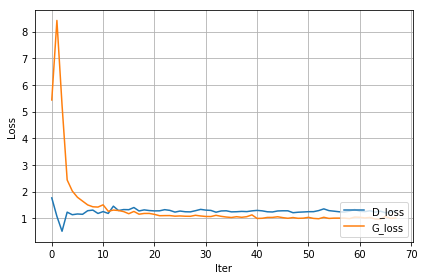

[69/300] - ptime: 9.79, loss_d: 1.256, loss_g: 1.008
Epoch 69: Training losses so far:


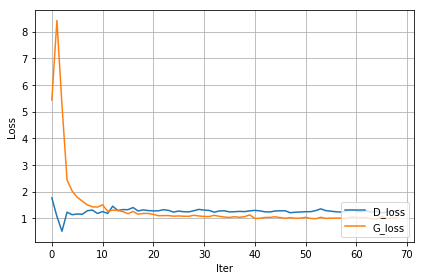

[70/300] - ptime: 9.53, loss_d: 1.227, loss_g: 1.007
Epoch 70: Training losses so far:


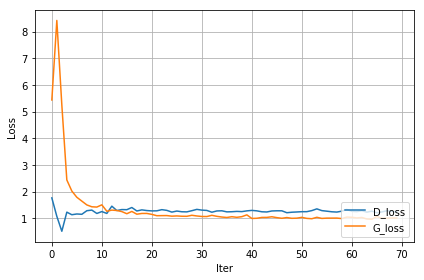

[71/300] - ptime: 8.15, loss_d: 1.204, loss_g: 1.021
Epoch 71: Training losses so far:


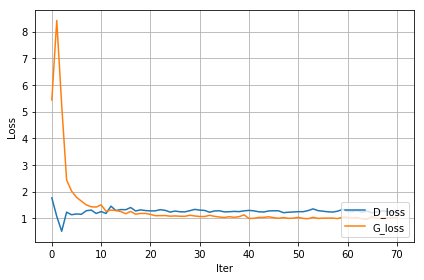

[72/300] - ptime: 8.16, loss_d: 1.202, loss_g: 1.019
Epoch 72: Training losses so far:


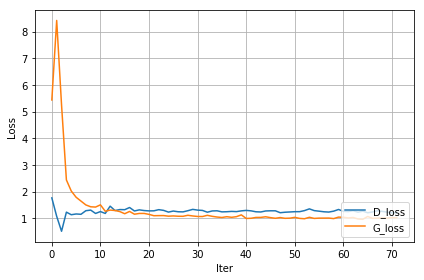

[73/300] - ptime: 8.19, loss_d: 1.246, loss_g: 0.995
Epoch 73: Training losses so far:


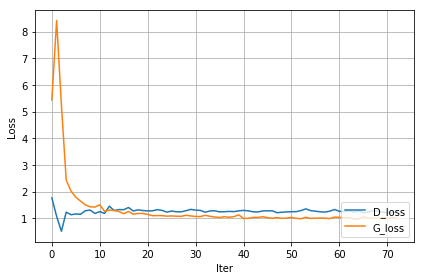

[74/300] - ptime: 8.23, loss_d: 1.228, loss_g: 1.038
Epoch 74: Training losses so far:


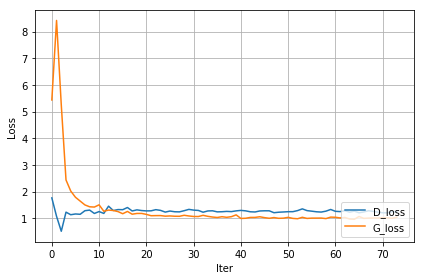

[75/300] - ptime: 8.21, loss_d: 1.228, loss_g: 1.062
Epoch 75: Training losses so far:


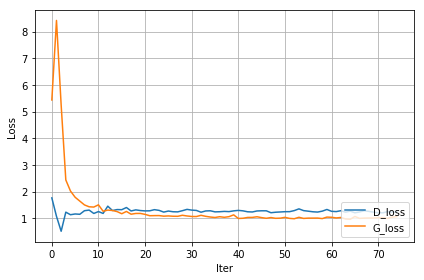

[76/300] - ptime: 8.14, loss_d: 1.263, loss_g: 1.053
Epoch 76: Training losses so far:


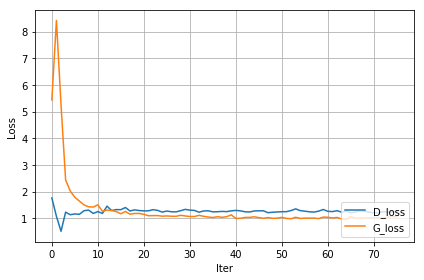

[77/300] - ptime: 8.22, loss_d: 1.172, loss_g: 1.058
Epoch 77: Training losses so far:


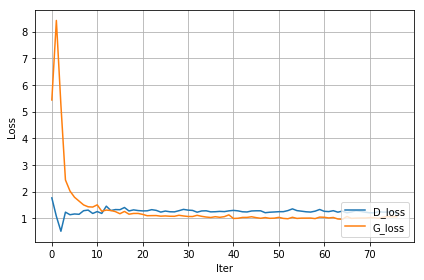

[78/300] - ptime: 8.15, loss_d: 1.204, loss_g: 0.983
Epoch 78: Training losses so far:


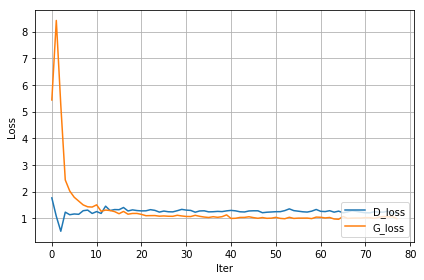

[79/300] - ptime: 8.16, loss_d: 1.223, loss_g: 1.079
Epoch 79: Training losses so far:


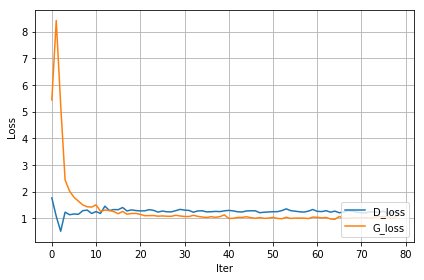

[80/300] - ptime: 8.16, loss_d: 1.189, loss_g: 1.075
Epoch 80: Training losses so far:


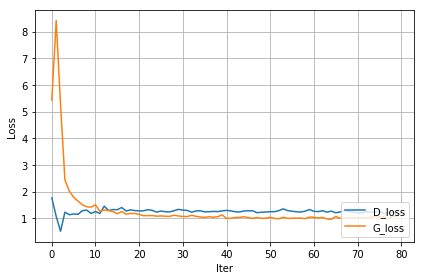

[81/300] - ptime: 8.15, loss_d: 1.152, loss_g: 1.034
Epoch 81: Training losses so far:


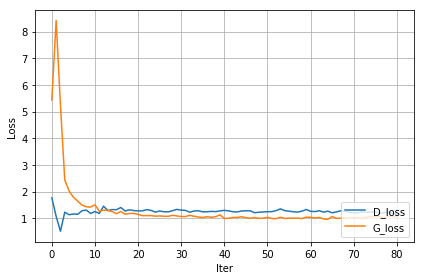

[82/300] - ptime: 8.21, loss_d: 1.188, loss_g: 1.063
Epoch 82: Training losses so far:


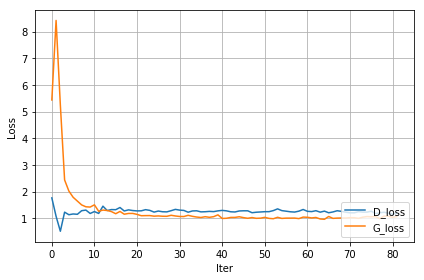

[83/300] - ptime: 8.15, loss_d: 1.186, loss_g: 1.062
Epoch 83: Training losses so far:


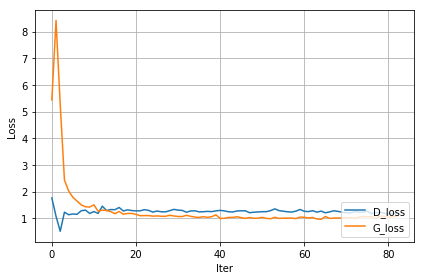

[84/300] - ptime: 8.16, loss_d: 1.150, loss_g: 1.098
Epoch 84: Training losses so far:


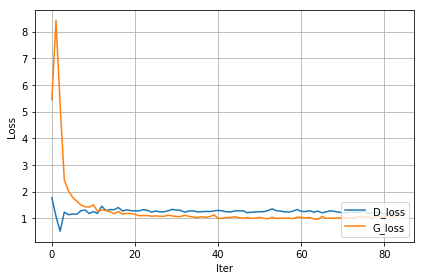

[85/300] - ptime: 8.15, loss_d: 1.128, loss_g: 1.118
Epoch 85: Training losses so far:


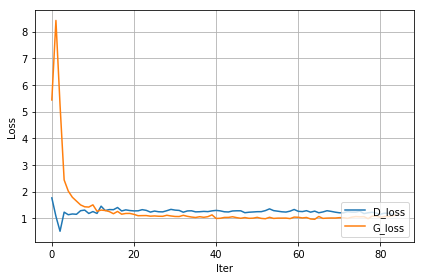

[86/300] - ptime: 8.19, loss_d: 1.182, loss_g: 1.097
Epoch 86: Training losses so far:


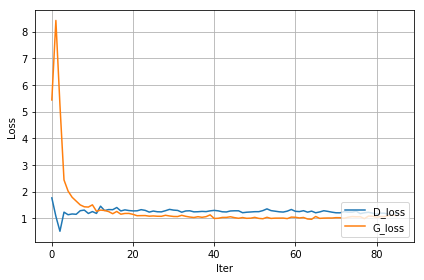

[87/300] - ptime: 8.14, loss_d: 1.181, loss_g: 1.041
Epoch 87: Training losses so far:


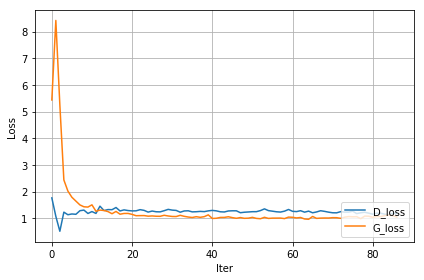

[88/300] - ptime: 8.14, loss_d: 1.163, loss_g: 1.103
Epoch 88: Training losses so far:


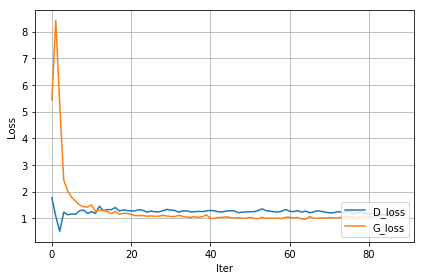

[89/300] - ptime: 8.15, loss_d: 1.178, loss_g: 1.108
Epoch 89: Training losses so far:


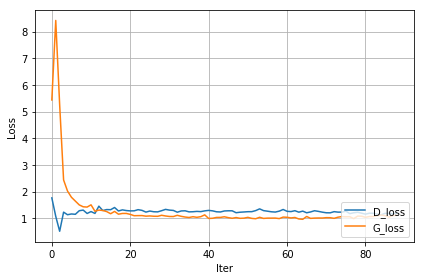

[90/300] - ptime: 8.19, loss_d: 1.145, loss_g: 1.089
Epoch 90: Training losses so far:


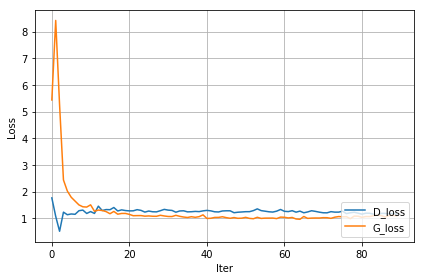

[91/300] - ptime: 8.22, loss_d: 1.189, loss_g: 1.125
Epoch 91: Training losses so far:


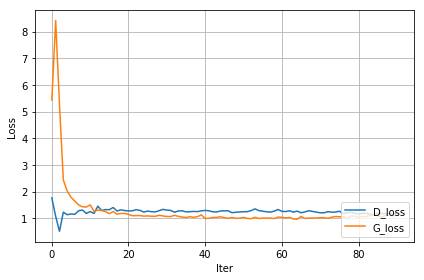

[92/300] - ptime: 8.16, loss_d: 1.134, loss_g: 1.094
Epoch 92: Training losses so far:


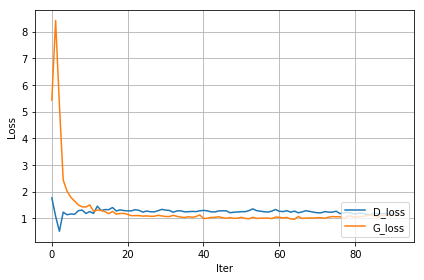

[93/300] - ptime: 8.15, loss_d: 1.118, loss_g: 1.103
Epoch 93: Training losses so far:


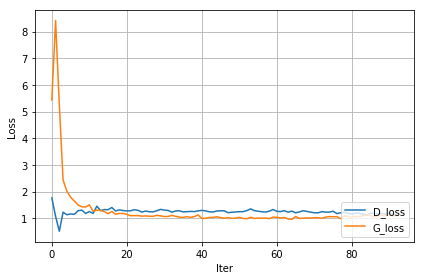

[94/300] - ptime: 8.17, loss_d: 1.188, loss_g: 1.166
Epoch 94: Training losses so far:


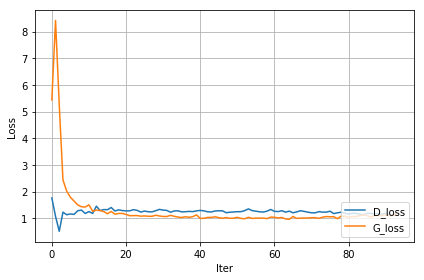

[95/300] - ptime: 8.15, loss_d: 1.116, loss_g: 1.118
Epoch 95: Training losses so far:


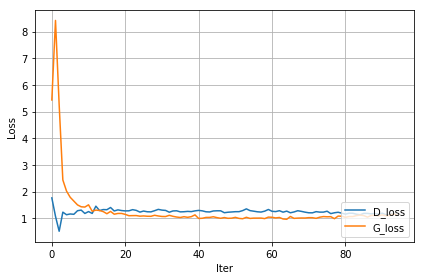

[96/300] - ptime: 8.15, loss_d: 1.123, loss_g: 1.111
Epoch 96: Training losses so far:


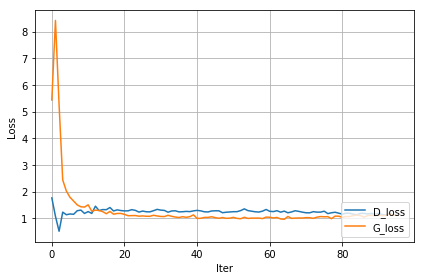

[97/300] - ptime: 8.14, loss_d: 1.090, loss_g: 1.122
Epoch 97: Training losses so far:


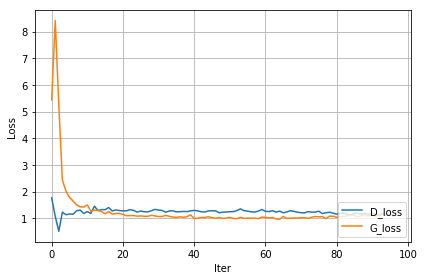

[98/300] - ptime: 8.21, loss_d: 1.107, loss_g: 1.152
Epoch 98: Training losses so far:


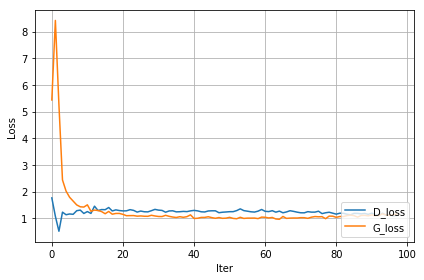

[99/300] - ptime: 8.14, loss_d: 1.098, loss_g: 1.148
Epoch 99: Training losses so far:


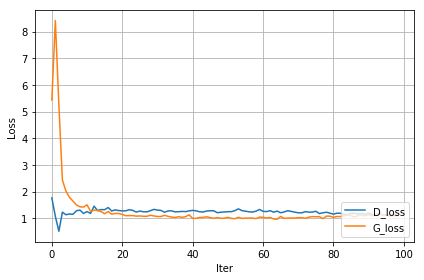

[100/300] - ptime: 8.16, loss_d: 1.108, loss_g: 1.092
Epoch 100: Training losses so far:


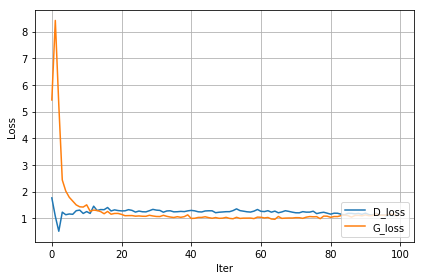

[101/300] - ptime: 8.16, loss_d: 1.119, loss_g: 1.143
Epoch 101: Training losses so far:


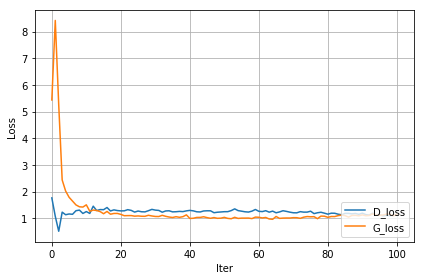

[102/300] - ptime: 8.18, loss_d: 1.103, loss_g: 1.185
Epoch 102: Training losses so far:


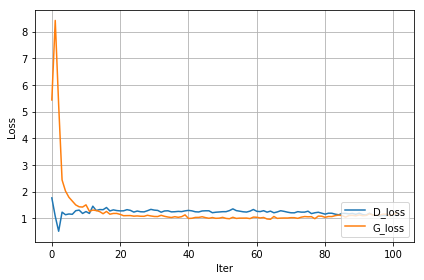

[103/300] - ptime: 8.15, loss_d: 1.104, loss_g: 1.158
Epoch 103: Training losses so far:


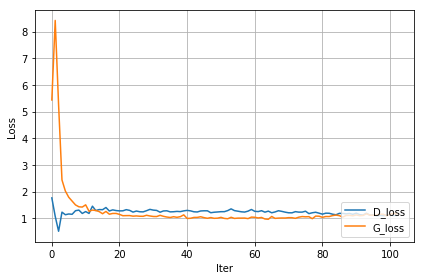

[104/300] - ptime: 8.22, loss_d: 1.133, loss_g: 1.207
Epoch 104: Training losses so far:


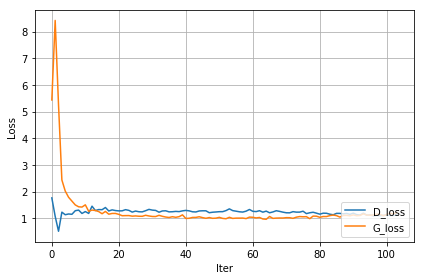

[105/300] - ptime: 8.32, loss_d: 1.133, loss_g: 1.141
Epoch 105: Training losses so far:


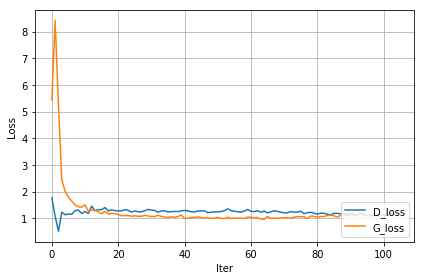

[106/300] - ptime: 8.15, loss_d: 1.015, loss_g: 1.138
Epoch 106: Training losses so far:


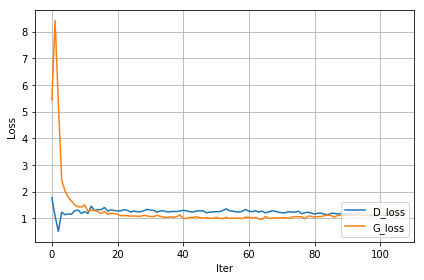

[107/300] - ptime: 8.17, loss_d: 1.219, loss_g: 1.207
Epoch 107: Training losses so far:


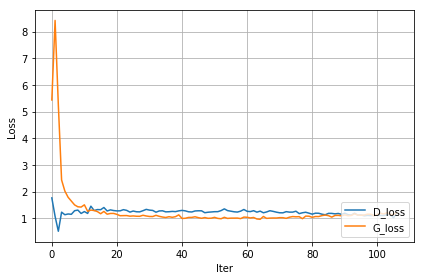

[108/300] - ptime: 8.14, loss_d: 1.103, loss_g: 1.222
Epoch 108: Training losses so far:


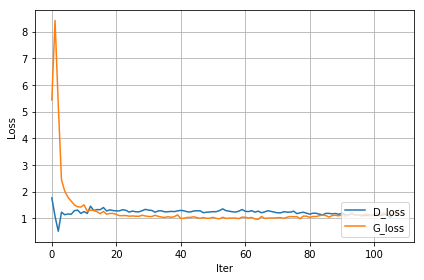

[109/300] - ptime: 8.15, loss_d: 1.078, loss_g: 1.187
Epoch 109: Training losses so far:


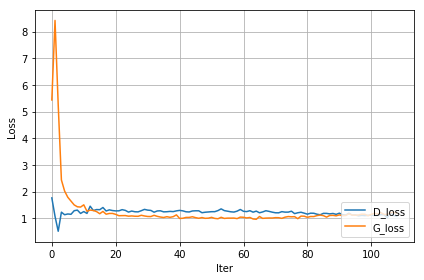

[110/300] - ptime: 8.21, loss_d: 1.048, loss_g: 1.239
Epoch 110: Training losses so far:


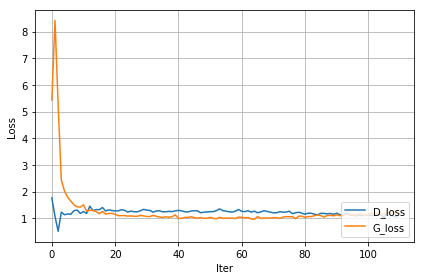

[111/300] - ptime: 8.15, loss_d: 1.001, loss_g: 1.195
Epoch 111: Training losses so far:


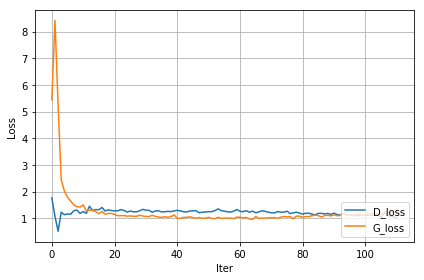

[112/300] - ptime: 8.15, loss_d: 1.142, loss_g: 1.206
Epoch 112: Training losses so far:


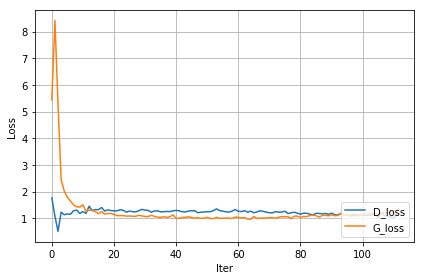

[113/300] - ptime: 8.15, loss_d: 1.012, loss_g: 1.223
Epoch 113: Training losses so far:


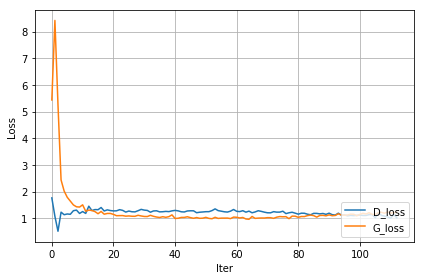

[114/300] - ptime: 8.19, loss_d: 1.082, loss_g: 1.233
Epoch 114: Training losses so far:


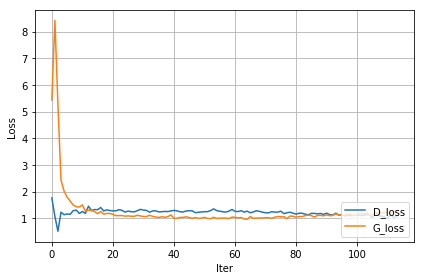

[115/300] - ptime: 8.16, loss_d: 1.003, loss_g: 1.172
Epoch 115: Training losses so far:


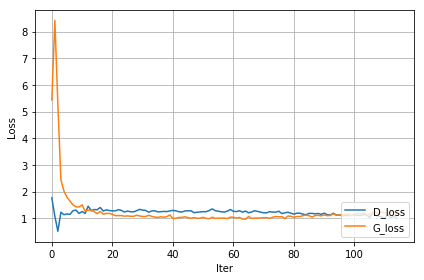

[116/300] - ptime: 8.34, loss_d: 1.035, loss_g: 1.223
Epoch 116: Training losses so far:


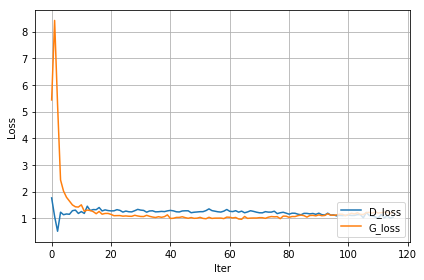

[117/300] - ptime: 9.87, loss_d: 1.088, loss_g: 1.275
Epoch 117: Training losses so far:


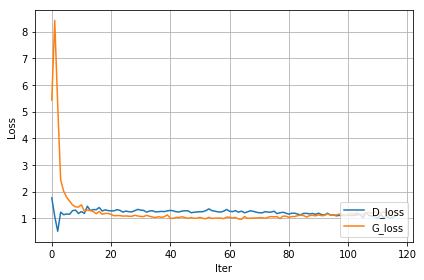

[118/300] - ptime: 9.91, loss_d: 1.046, loss_g: 1.275
Epoch 118: Training losses so far:


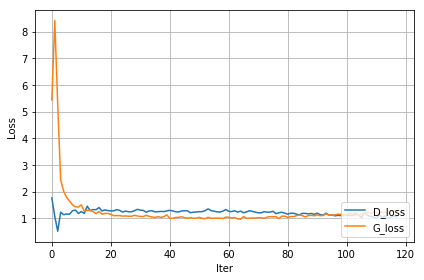

[119/300] - ptime: 10.21, loss_d: 1.032, loss_g: 1.249
Epoch 119: Training losses so far:


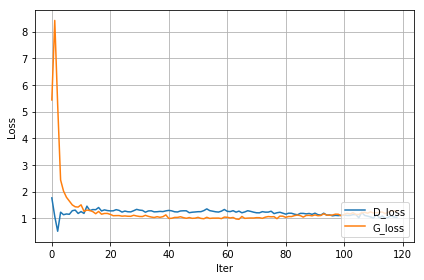

[120/300] - ptime: 10.50, loss_d: 1.037, loss_g: 1.259
Epoch 120: Training losses so far:


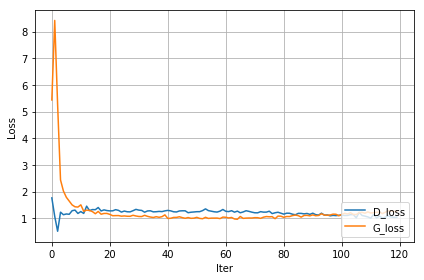

[121/300] - ptime: 10.13, loss_d: 1.028, loss_g: 1.252
Epoch 121: Training losses so far:


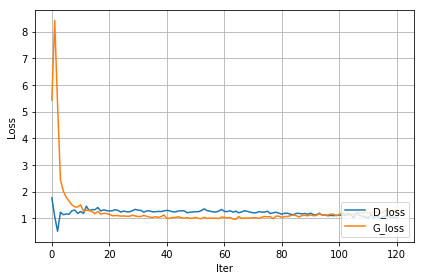

[122/300] - ptime: 10.28, loss_d: 0.976, loss_g: 1.253
Epoch 122: Training losses so far:


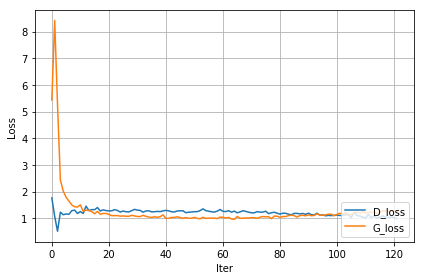

[123/300] - ptime: 10.25, loss_d: 1.002, loss_g: 1.271
Epoch 123: Training losses so far:


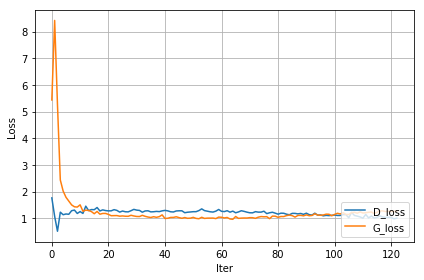

[124/300] - ptime: 10.42, loss_d: 1.089, loss_g: 1.326
Epoch 124: Training losses so far:


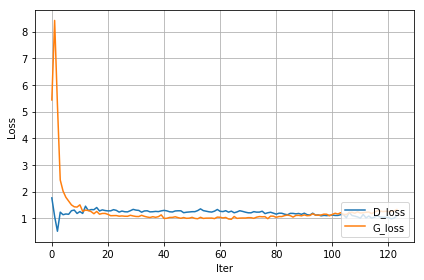

[125/300] - ptime: 10.00, loss_d: 0.973, loss_g: 1.258
Epoch 125: Training losses so far:


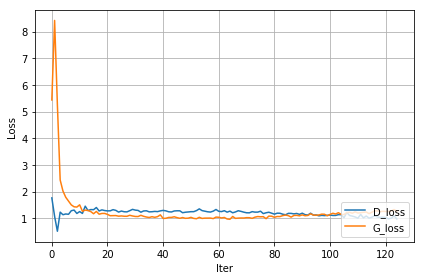

[126/300] - ptime: 10.41, loss_d: 0.958, loss_g: 1.325
Epoch 126: Training losses so far:


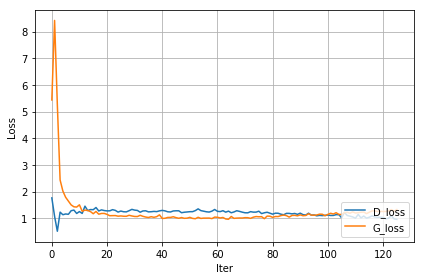

[127/300] - ptime: 10.46, loss_d: 1.042, loss_g: 1.328
Epoch 127: Training losses so far:


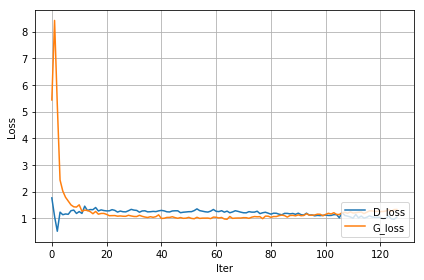

[128/300] - ptime: 10.41, loss_d: 1.095, loss_g: 1.456
Epoch 128: Training losses so far:


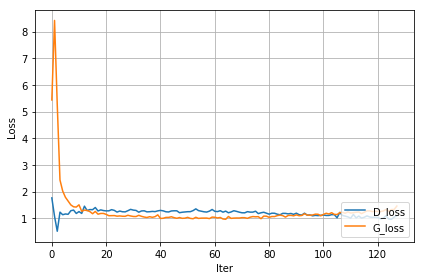

[129/300] - ptime: 10.11, loss_d: 0.953, loss_g: 1.310
Epoch 129: Training losses so far:


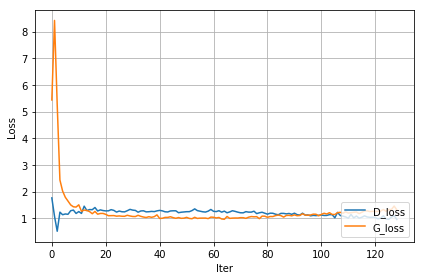

[130/300] - ptime: 10.32, loss_d: 0.930, loss_g: 1.343
Epoch 130: Training losses so far:


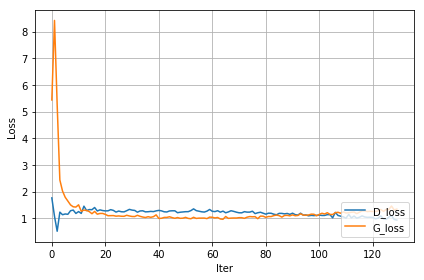

[131/300] - ptime: 10.46, loss_d: 0.936, loss_g: 1.339
Epoch 131: Training losses so far:


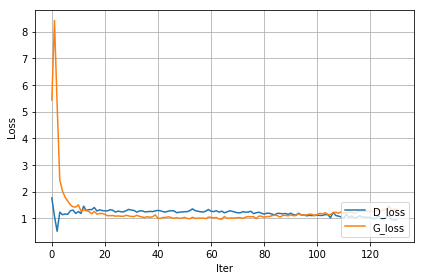

[132/300] - ptime: 10.44, loss_d: 0.956, loss_g: 1.342
Epoch 132: Training losses so far:


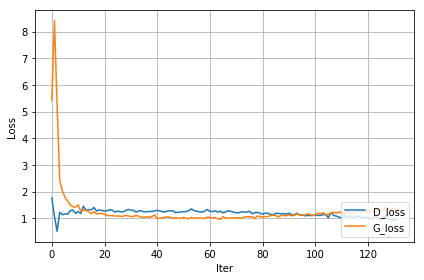

In [ ]:

# results save folder
if not os.path.isdir('soccer_DCGAN_results'):
    os.mkdir('soccer_DCGAN_results')
if not os.path.isdir('soccer_DCGAN_results/Random_results'):
    os.mkdir('soccer_DCGAN_results/Random_results')
if not os.path.isdir('soccer_DCGAN_results/Fixed_results'):
    os.mkdir('soccer_DCGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0] # mini_batch=batch_size

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze() # torch.squeeze: Returns a tensor with all the dimensions of input of size 1 removed
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 1000)).view(-1, 1000, 1, 1) # Ramdom between iterations! # size: mini_batch*1000*1*1
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss # Add the loss of discriminating real image and fake image

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.data[0])

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 1000)).view(-1, 1000, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'soccer_DCGAN_results/Random_results/soccer_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'soccer_DCGAN_results/Fixed_results/soccer_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
    
    # Track the change of losses in each epoch: if the losses seems to be failing, then disrupt the running code and adjust
    print('Epoch %d: Training losses so far:' % (epoch + 1))
    show_train_hist(train_hist,show = True)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), "soccer_DCGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "soccer_DCGAN_results/discriminator_param.pkl")
with open('soccer_DCGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path='soccer_DCGAN_results/soccer_DCGAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = 'soccer_DCGAN_results/Fixed_results/soccer_DCGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('soccer_DCGAN_results/generation_animation.gif', images, fps=5)